In [59]:
import numpy as np
import pandas as pd

import os
import glob

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.models import resnet18, resnet50, mobilenet_v3_small
import torch.nn as nn
import torch.nn.functional as F

import pytorch_metric_learning
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning import losses, miners, samplers, testers, trainers, distances
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

from pytorch_metric_learning.utils.inference import CustomKNN
import faiss

import open_clip

from sklearn.model_selection import train_test_split

from online_triplet_loss.losses import *


from tqdm.notebook import tqdm

from PIL import Image
import random



from matplotlib import pyplot as plt
import seaborn as sns

import warnings

import logging

warnings.filterwarnings("ignore")

### Prepare dataframe

In [400]:
df_train = pd.read_csv("Stanford_Online_Products/Ebay_train.txt", sep=' ', skiprows=1, names=["image_id", "class_id", "super_class_id", "path"])

df_test = pd.read_csv("Stanford_Online_Products/Ebay_test.txt", sep=' ', skiprows=1, names=["image_id", "class_id", "super_class_id", "path"])

In [401]:
df_train['class_id'] = df_train['class_id']-1
df_test['class_id'] = df_test['class_id']-1

In [402]:
num_classes = len(df_train['class_id'].value_counts())
num_classes

11318

In [366]:
groups = df_train.groupby(['super_class_id'])

In [382]:
for num, group in groups:
    print(f"group {num}:")
    sub_group=sorted(group['class_id'].value_counts().index.values)
    val_len=int(0.75*len(sub_group))
    train_indexes = sub_group[:val_len]
    val_indexes = sub_group[val_len:]
    print(train_indexes)
    print(val_indexes)
    print(sub_group)

group (1,):
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

In [403]:
def train_valid_split(dataset, valid_size):

    train_classes = []
    valid_classes = []

    groups = dataset.groupby(['super_class_id'])

    train_size = 1-valid_size

    for num, group in groups:

        sub_indexes=sorted(group['class_id'].value_counts().index.values)
        train_len=int(train_size*len(sub_indexes))
        train_classes.extend(sub_indexes[:train_len])
        valid_classes.extend(sub_indexes[train_len:])



    train_set = dataset[dataset['class_id'].isin(train_classes)]
    valid_set = dataset[dataset['class_id'].isin(valid_classes)]

    return train_set, valid_set

In [404]:
df_train, df_valid = train_valid_split(df_train, 0.15)

In [413]:
df_train.shape

(50325, 4)

In [414]:
df_valid.shape

(9226, 4)

### Check that we have all superclasses in train and valid sets

In [415]:
df_train['super_class_id'].value_counts().sort_index()

super_class_id
1     3524
2     4865
3     4938
4     4199
5     2579
6     4210
7     5400
8     5677
9     2946
10    3661
11    4671
12    3655
Name: count, dtype: int64

In [416]:
df_valid['super_class_id'].value_counts().sort_index()

super_class_id
1      644
2      983
3      907
4      786
5      414
6      803
7      904
8     1054
9      526
10     706
11     799
12     700
Name: count, dtype: int64

In [417]:
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

In [419]:
print(f"Length of train {len(df_train)}")
print(f"Length of validation {len(df_valid)}")
print(f"Length of test {len(df_test)}")

Length of train 50325
Length of validation 9226
Length of test 60502


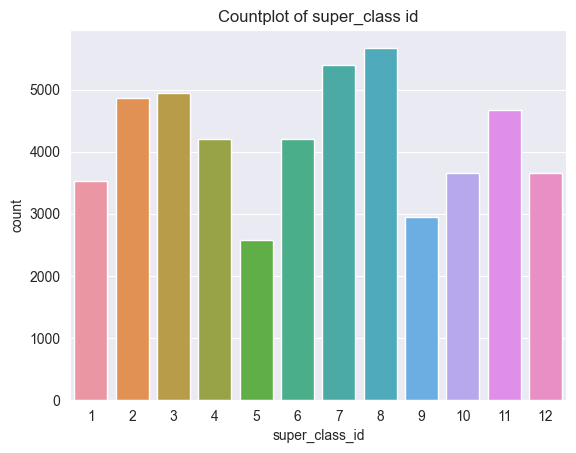

In [420]:
plt.title("Countplot of super_class id")
sns.countplot(data=df_train, x='super_class_id')
plt.show()

In [421]:
PATH = "Stanford_Online_Products"

In [422]:
class ProductDataset(Dataset):
    def __init__(self, df, path, transform=None):
        self.data_csv = df
        self.transform = transform
        self.path = path
        self.images = df["path"].values
        self.labels = df["class_id"].values
        self.index = df.index.values



    def __len__(self):
        return len(self.images)


    def __getitem__(self, item):
        image_name = self.images[item]
        image_path = self.path + "/" + image_name
        ###### Anchor Image #######
        img = Image.open(image_path).convert("RGB")
        label = self.labels[item]



        # if self.preprocess != None:
        #     img = self.preprocess(img)


        if self.transform != None:
            img = self.transform(img)

        return img, label





train_transform =transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(scale=(0.16, 1), ratio=(0.75, 1.33), size=224),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [423]:
trainDS = ProductDataset(df=df_train, path=PATH, transform=train_transform)

testDS = ProductDataset(df=df_test, path=PATH, transform=val_transform)

validDS = ProductDataset(df=df_valid, path=PATH, transform=val_transform)

In [424]:
BATCH_SIZE = 128

In [425]:
#use hierarchical sampler with super_class_id and class_id

train_sampler = samplers.HierarchicalSampler(
        labels = df_train[['super_class_id', 'class_id']].values,
        batch_size = BATCH_SIZE,
        samples_per_class = 4,
        batches_per_super_tuple=4,
        super_classes_per_batch=2,
        inner_label=1,
        outer_label=0,
    )

valid_sampler = samplers.HierarchicalSampler(
        labels = df_valid[['super_class_id', 'class_id']].values,
        batch_size = BATCH_SIZE,
        samples_per_class = 4,
        batches_per_super_tuple=4,
        super_classes_per_batch=2,
        inner_label=1,
        outer_label=0,
    )

In [426]:
trainLoader = DataLoader(trainDS, batch_sampler = train_sampler)

validLoader = DataLoader(validDS, batch_sampler = valid_sampler)

testLoader = DataLoader(testDS, batch_size=BATCH_SIZE, shuffle=False)

In [427]:
images, labels = next(iter(trainLoader))

In [428]:
images[0].shape

torch.Size([3, 224, 224])

In [429]:
images[0]

tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [1.7009, 1.7865, 1.8208,  ..., 1.7865, 1.7865, 1.7694],
         [1.7352, 1.8037, 1.8208,  ..., 1.7865, 1.7865, 1.7694],
         [1.7694, 1.8037, 1.8208,  ..., 1.7865, 1.7865, 1.7694]],

        [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         ...,
         [1.8683, 1.9734, 2.0259,  ..., 1.9384, 1.9209, 1.9034],
         [1.8683, 1.9559, 1.9909,  ..., 1.9384, 1.9209, 1.9034],
         [1.8683, 1.9384, 1.9734,  ..., 1.9384, 1.9209, 1.9034]],

        [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.

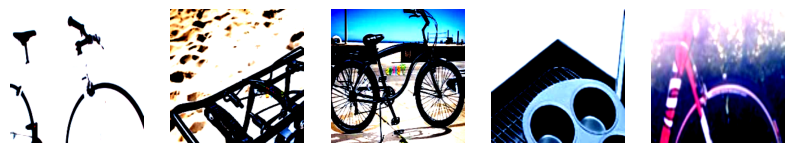

In [430]:
plt.figure(figsize=(10, 50))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.axis("off")
plt.show()

In [431]:
import timm
mobilenetv3 = timm.create_model('mobilenetv3_small_100', pretrained=True)

In [432]:
mobilenetv3

MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): ReLU(inplace=True)
          (conv_expand): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (gate): Hardsigmoid()
        )
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          

In [433]:
EMBED_DIMS = 128
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 0.0001
EPOCHS = 10

In [434]:
class Mobile_ArcFace(nn.Module):
    def __init__(self):
        super().__init__()
        self.Feature_Extractor = mobilenetv3
        num_filters = self.Feature_Extractor.classifier.in_features
        self.Feature_Extractor.classifier = nn.Sequential(
                  nn.Linear(num_filters, EMBED_DIMS))

    def forward(self,x):
        x = self.Feature_Extractor(x)
        x = F.normalize(x, p=2, dim=1)

        return x

In [435]:
model = Mobile_ArcFace()
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [436]:
num_classes

11318

In [437]:
# Set the loss function
# criterion = losses.TripletMarginLoss(margin=0.1)
#distance = distances.LpDistance(p=2, normalize_embeddings=False, power=1)

# loss_func = losses.MarginLoss(margin=0.2,
#                 nu=0,
#                 beta=1.2,
#                 triplets_per_anchor="all",
#                 learn_beta=True,
#                 num_classes=None)

loss_func = losses.ArcFaceLoss(num_classes, EMBED_DIMS, margin=28.6, scale=64)

loss_optimizer = torch.optim.Adam(loss_func.parameters(), lr=0.001)

#loss_func = losses.TripletMarginLoss(margin=0.2)

#loss_optimizer = torch.optim.SGD(loss_func.parameters(), lr=0.0001, momentum=0.9)

#mining_func = miners.TripletMarginMiner(margin=0.2, type_of_triplets="semihard")



# accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)

In [438]:
def top_k_accuracy(predictions, labels):
    '''
    compute number of valid results among first k-1 nearest neighbours
    first neighbour is always itself, that's why it is not taken into consideration
    '''

    accur = 0
    for i, label in enumerate(labels):
        #if correct item is among 4 neighbors than we have a success
        #not include itself -> ([1:])
        accur += np.sum(predictions[i][1:]==label.item())>0
    return accur/len(predictions)

In [439]:
class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        #distance is calculated by inner product
        self.index = faiss.IndexFlatIP(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        #use 5 neighbors
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        labels = self.y[indices]
        #predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return indices, labels


In [440]:
def train(model, loss_func, train_loader, optimizer, epoch):
    model.train()
    losses = []
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        loss_optimizer.zero_grad()
        embeddings = model(data)
        #indices_tuple = mining_func(embeddings, labels)
        #loss = loss_func(embeddings, labels, indices_tuple)
        loss = loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()
        loss_optimizer.step()
        if batch_idx % 20 == 0:
            # print(
            #     "Epoch {} Iteration {}: Loss = {:.4f}, Number of mined triplets = {}".format(
            #         epoch, batch_idx, loss, mining_func.num_triplets
            #     )
            # )
            print(
                "Epoch {} Iteration {}: Loss = {:.4f}".format(epoch, batch_idx, loss)
            )
        losses.append(loss.detach().numpy())
    return np.mean(losses)

### convenient function from pytorch-metric-learning ###
# def get_all_embeddings(dataset, model):
#     tester = testers.BaseTester(dataloader_num_workers=16)
#     return tester.get_all_embeddings(dataset, model)

def get_all_embeddings(dataset, model):

    #make dataloader of 1 element in the batch
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    all_embeddings = torch.zeros(len(dataloader), EMBED_DIMS)
    all_labels = torch.zeros(len(dataloader), 1)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(tqdm(dataloader)):
            images, labels = data[0], data[1]
            embeddings = model(images)
            all_embeddings[i]=embeddings
            all_labels[i]=labels

    return all_embeddings, all_labels



### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def eval(valid_set, model, accuracy_calculator):
    print("compute embeddings of valid set")
    valid_embeddings, valid_labels = get_all_embeddings(valid_set, model)
    valid_loss = loss_func(valid_embeddings, valid_labels)

    #valid_labels = valid_labels.squeeze(1)
    print("Computing accuracy")
    faiss_knn = FaissKNeighbors()
    faiss_knn.fit(valid_embeddings.numpy(), valid_labels.numpy())
    indices, predicted_labels = faiss_knn.predict(valid_embeddings.numpy())
    top_4_accuracy = accuracy_calculator(predicted_labels, valid_labels)
    # accuracies = accuracy_calculator.get_accuracy(
    #     valid_embeddings, valid_labels, valid_embeddings, valid_labels, False)
    print("Validation set accuracy (Accuracy@4) = {}".format(top_4_accuracy))

    return valid_loss


In [ ]:
train_loss = []
min_loss = 10
for epoch in range(1, EPOCHS + 1):
    epoch_loss = train(model, loss_func, trainLoader, optimizer, epoch)
    print(f"Epoch{epoch}/{EPOCHS}: Mean train Loss {epoch_loss: .4f}")
    train_loss.append(epoch_loss)
    if epoch_loss < min_loss:
        torch.save(model, "models/model.pts")
        min_loss = epoch_loss
    valid_loss = eval(validDS, model, top_k_accuracy)
    print(f"Valid loss: {valid_loss: .4f}")

Epoch 1 Iteration 0: Loss = 53.3705


In [ ]:
torch.save(model, "models/model.pts")